# Diesel Fuel Price Prediction

Data from
https://www.eia.gov/petroleum/gasdiesel/

Future ideas:
* do gasoline instead (more interesting to recruiters?)
* Include crude oil prices

First pass around, I am gonna deal with missing data by really limiting my dataset.  Here's the basic cuts:
* No 'Weekly West Coast (PADD 5) Except California No 2 Diesel Retail Prices  (Dollars per Gallon)' because it doesn't show up till 2011
* I'm gonna ignore all data before May 26, 1997, because several columns don't show up until then
Goal is to use XGBoost in order to create a time series predictive model for latest price of Diesel

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import time
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from bayes_opt import BayesianOptimization

In [128]:
# Path to the Excel file
file_path = 'psw18vwall.xls'

# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df = pd.read_excel(file_path, sheet_name='Data 1', header=2)

# drop one column
df.drop('Weekly West Coast (PADD 5) Except California No 2 Diesel Retail Prices  (Dollars per Gallon)', axis=1, inplace=True)

# only after date when all columns present
df = df.loc[(df['Date'] > '1997-05-25')]

# rename columns
df = df.rename(columns={'Weekly U.S. No 2 Diesel Retail Prices  (Dollars per Gallon)': 'US',
                        'Weekly East Coast No 2 Diesel Retail Prices  (Dollars per Gallon)': 'eastCoast',
                        'Weekly New England (PADD 1A) No 2 Diesel Retail Prices  (Dollars per Gallon)': 'newEng',
                        'Weekly Central Atlantic (PADD 1B) No 2 Diesel Retail Prices  (Dollars per Gallon)': 'cenAtl',
                        'Weekly Lower Atlantic (PADD 1C) No 2 Diesel Retail Prices  (Dollars per Gallon)': 'lowAtl',
                        'Weekly Midwest No 2 Diesel Retail Prices  (Dollars per Gallon)': 'midwest',
                        'Weekly Gulf Coast No 2 Diesel Retail Prices  (Dollars per Gallon)': 'gulf',
                        'Weekly Rocky Mountain No 2 Diesel Retail Prices  (Dollars per Gallon)': 'rkyMtn',
                        'Weekly West Coast No 2 Diesel Retail Prices  (Dollars per Gallon)': 'westCoast',
                        'Weekly California No 2 Diesel Retail Prices  (Dollars per Gallon)': 'cali'
                       })

# # reset index
df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(df)

           Date     US  eastCoast  newEng  cenAtl  lowAtl  midwest   gulf  \
0    1997-05-26  1.196      1.184   1.238   1.254   1.148    1.198  1.166   
1    1997-06-02  1.190      1.178   1.238   1.254   1.140    1.187  1.162   
2    1997-06-09  1.187      1.173   1.237   1.249   1.135    1.184  1.158   
3    1997-06-16  1.172      1.161   1.240   1.232   1.124    1.167  1.141   
4    1997-06-23  1.162      1.155   1.229   1.231   1.115    1.154  1.134   
...         ...    ...        ...     ...     ...     ...      ...    ...   
1383 2023-11-27  4.146      4.121   4.447   4.467   3.959    4.115  3.793   
1384 2023-12-04  4.092      4.139   4.432   4.458   3.990    4.025  3.737   
1385 2023-12-11  3.987      4.050   4.418   4.406   3.880    3.900  3.640   
1386 2023-12-18  3.894      3.969   4.362   4.336   3.793    3.806  3.569   
1387 2023-12-25  3.914      4.022   4.339   4.323   3.879    3.798  3.608   

      rkyMtn  westCoast   cali  
0      1.275      1.236  1.320  
1      1.

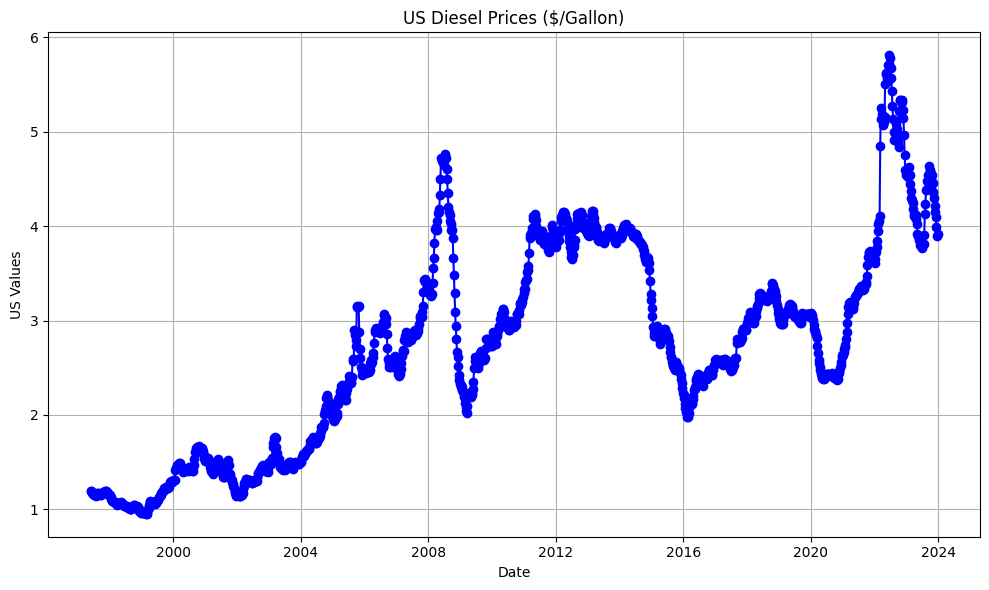

In [129]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['US'], marker='o', color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Diesel Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

In [130]:
# adding column for prediction
df['diff'] = df['US'].diff(-1)

In [131]:
df

,Date,US,eastCoast,newEng,cenAtl,lowAtl,midwest,gulf,rkyMtn,westCoast,cali,diff
0,1997-05-26,1.196,1.184,1.238,1.254,1.148,1.198,1.166,1.275,1.236,1.320,0.006
1,1997-06-02,1.190,1.178,1.238,1.254,1.140,1.187,1.162,1.266,1.240,1.325,0.003
2,1997-06-09,1.187,1.173,1.237,1.249,1.135,1.184,1.158,1.262,1.240,1.317,0.015
3,1997-06-16,1.172,1.161,1.240,1.232,1.124,1.167,1.141,1.246,1.231,1.302,0.010
4,1997-06-23,1.162,1.155,1.229,1.231,1.115,1.154,1.134,1.233,1.220,1.293,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...
1383,2023-11-27,4.146,4.121,4.447,4.467,3.959,4.115,3.793,4.204,4.997,5.579,0.054
1384,2023-12-04,4.092,4.139,4.432,4.458,3.990,4.025,3.737,4.128,4.912,5.480,0.105
1385,2023-12-11,3.987,4.050,4.418,4.406,3.880,3.900,3.640,4.049,4.802,5.367,0.093
1386,2023-12-18,3.894,3.969,4.362,4.336,3.793,3.806,3.569,3.933,4.655,5.231,-0.020


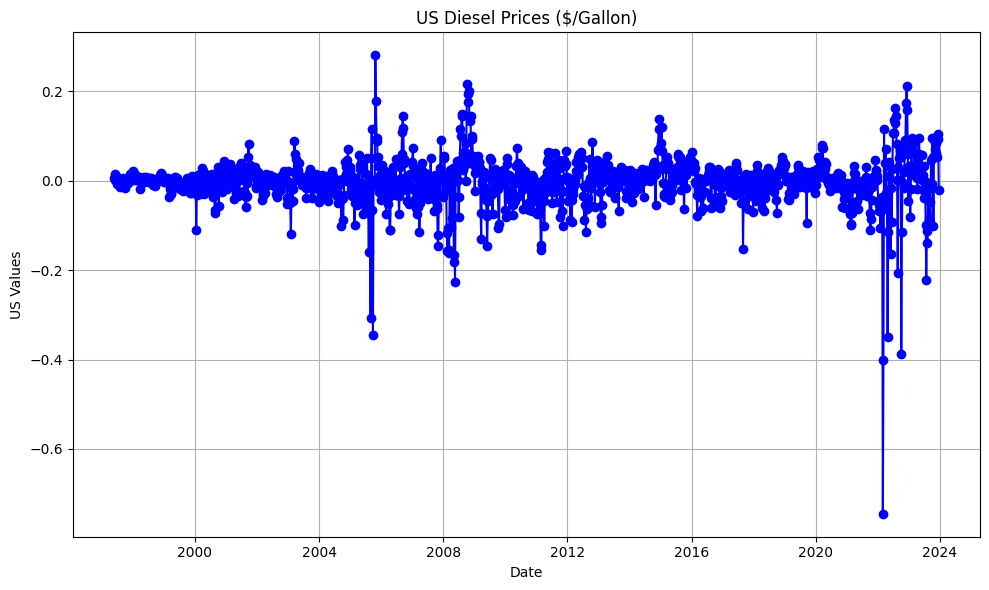

In [132]:
# Plotting differences
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['diff'], marker='o', color='blue')#, linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Diesel Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

## hyperparameter tuning



In [8]:
# setting aside a test set
# keep it secret, keep it safe
testSize = 104
df_train, df_test = df[:-testSize].drop('Date', axis=1), df[-testSize:].drop('Date', axis=1)

X, y = df_train.drop('diff', axis=1), df_train['diff']

In [57]:
# Objective function for Bayesian optimization
def objective(n_estimators, learning_rate, alpha, reg_lambda, colsample_bytree, max_depth):
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate#,
        # 'alpha': alpha,
        # 'reg_lambda': reg_lambda,
        # 'colsample_bytree': colsample_bytree,
        # 'max_depth': int(max_depth)
    }
    
    xgb = XGBRegressor(**params)
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=52, test_size=1)
    
    mse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return -np.mean(mse_scores)  # Minimize negative mean squared error

# Define the search space
pbounds = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.5),
    'alpha': (0, 20),
    'reg_lambda': (0, 20),
    'colsample_bytree': (0.1,1),
    'max_depth': (1,7)
}

# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=13,  # Number of random exploration points
    n_iter=47,      # Number of iterations for the bayesian optimization
)

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | -0.00149  | 7.491     | 0.9556    | 0.3687    | 4.592     | 120.2     | 3.12      |
| 2         | -0.001475 | 1.162     | 0.8796    | 0.3045    | 5.248     | 59.26     | 19.4      |
| 3         | -0.001398 | 16.65     | 0.2911    | 0.09909   | 2.1       | 186.9     | 10.5      |
| 4         | -0.001592 | 8.639     | 0.3621    | 0.3098    | 1.837     | 181.5     | 7.327     |
| 5         | -0.001542 | 9.121     | 0.8067    | 0.1078    | 4.085     | 316.6     | 0.929     |
| 6         | -0.001441 | 12.15     | 0.2535    | 0.04188   | 6.693     | 484.5     | 16.17     |
| 7         | -0.001463 | 6.092     | 0.1879    | 0.3453    | 3.641     | 104.9     | 9.904     |
| 8         | -0.001466 | 0.6878    | 0.9184    | 0.1368    | 4.975     | 190.3     | 10.4      |
| 9         | -0.001

In [58]:
# # make a train/test split of this data
# def timeSeriesTrainTestSplit(df, testEntry):
#     df_train = df[:-testEntry].drop('Date', axis=1)
#     df_test = df.iloc[[-testEntry]].drop('Date', axis=1)
#     return df_train.drop('nextWeek', axis=1), df_test.drop('nextWeek', axis=1), df_train['nextWeek'], df_test['nextWeek']

# make a train/test split of this data
def timeSeriesTrainTestSplit(df, testEntry):
    df_train = df[:-testEntry].drop('Date', axis=1)
    df_test = df.iloc[[-testEntry]].drop('Date', axis=1)
    return df_train.drop('diff', axis=1), df_test.drop('diff', axis=1), df_train['diff'], df_test['diff']

# make XGBoost predictor/prediction
def xgboost_forecast(X_train, y_train, X_test):
    # Create an XGBoost regressor model
    xgb = XGBRegressor(
        objective ='reg:squarederror',
        n_estimators=int(best_params['n_estimators']),
        learning_rate=best_params['learning_rate'],
        alpha=best_params['alpha'],
        reg_lambda=best_params['reg_lambda'],
        colsample_bytree=best_params['colsample_bytree'],
        max_depth=int(best_params['max_depth'])
    )
    # fit model
    xgb.fit(X_train, y_train)
    # make prediction for next step
    return xgb.predict(X_test)[0]

# time series cross validation
def tscv_mine(df, n_tests):
    predictions = []
    realPrices = []
    diffs = []
    for i in range(n_tests):
        print(i)
        X_train, X_test, y_train, y_test = timeSeriesTrainTestSplit(df, n_tests-i)
        predictions.append(xgboost_forecast(X_train, y_train, X_test))
        realPrices.append(y_test.iloc[-1])
        diffs.append(abs(predictions[-1] - realPrices[-1]))
    errSq = [diff**2 for diff in diffs]
    MSE = sum(errSq)/n_tests
    return predictions, realPrices, diffs, MSE

# compare to naive prediction
# time series cross validation
def tscv_naive(df, n_tests):
    diffs = []
    for i in range(n_tests):
        X_train, X_test, y_train, y_test = timeSeriesTrainTestSplit(df, n_tests-i)
        # diffs.append(abs(y_train.iloc[-1] - y_test.iloc[-1])) # for predicting prices
        diffs.append(abs(y_test.iloc[-1])) # for predicting differences
    errSq = [diff**2 for diff in diffs]
    MSE = sum(errSq)/n_tests
    return diffs, MSE

In [59]:
# just out of curiousity, what is in-sample error
df_inSet = df[:-testSize]
df_noLast = df_inSet.drop(df_inSet.index[-1])

# remember to drop last row 
df_noLast = df.drop(df.index[-1])


n_tests = 104

In [133]:
%%time
# predictions, realPrices, diffs, MSE = tscv_mine(df_noLast,n_tests)
diffsN, MSEN = tscv_naive(df_noLast,n_tests)
print('XGB: ' + str(MSE) + ', Naive: ' + str(MSEN))

XGB: 0.01824094421187044, Naive: 0.016016624999999993
CPU times: user 200 ms, sys: 7.76 ms, total: 208 ms
Wall time: 217 ms


## adding more data

The naive forecast is beating my XGBoost model, even after tuning hyperparameters with Bayesian optimization. Let's see if we can add some data to improve this metric.

In [120]:
# Path to the Excel file
file_path_crude = 'PET_PRI_SPT_S1_W.xls'

# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_crude = pd.read_excel(file_path_crude, sheet_name='Data 1', header=2)

# rename columns
df_crude = df_crude.rename(columns={'Weekly Cushing, OK WTI Spot Price FOB  (Dollars per Barrel)': 'Crude'})

# shift Date to align with petroleum prices
df_crude['Date'] = df_crude['Date'] + pd.Timedelta(days=3)

# Path to the Excel file
file_path_petrol = 'psw18vwall.xls'

# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_petrol = pd.read_excel(file_path_petrol, sheet_name='Data 1', header=2)

# rename columns
df_petrol = df_petrol.rename(columns={'Weekly U.S. No 2 Diesel Retail Prices  (Dollars per Gallon)': 'Petrol'})

# inner join
df = pd.merge(df_petrol[['Date','Petrol']], df_crude[['Date','Crude']], on='Date', how='inner')

# # # only after date when all columns present
# # df = df.loc[(df['Date'] > '1997-05-25')]

# adding in some difference columns
for i in range(11):
    crudeCol = 'CrudeDiff' + str(i+1)
    petroCol = 'PetroDiff' + str(i+1)
    df[crudeCol] = df['Crude'].diff(i+1)
    df[petroCol] = df['Petrol'].diff(i+1)

# target to predict
df['TargetDelta'] = df['Petrol'].diff(-1)

# dropping rows with now empty information
df = df.drop(df.index[:11])
df = df.drop(df.index[-1])

# reset index
df.reset_index(drop=True, inplace=True)

# remove dates as they don't go into XGBoost
df.drop('Date', axis=1, inplace=True)

df

,Petrol,Crude,CrudeDiff1,PetroDiff1,CrudeDiff2,PetroDiff2,CrudeDiff3,PetroDiff3,CrudeDiff4,PetroDiff4,...,PetroDiff7,CrudeDiff8,PetroDiff8,CrudeDiff9,PetroDiff9,CrudeDiff10,PetroDiff10,CrudeDiff11,PetroDiff11,TargetDelta
0,1.101,18.24,0.10,0.003,0.03,0.002,0.31,0.002,1.04,0.000,...,-0.004,2.59,-0.007,3.80,-0.008,3.09,-0.006,3.42,-0.005,0.003
1,1.098,18.26,0.02,-0.003,0.12,0.000,0.05,-0.001,0.33,-0.001,...,-0.008,2.19,-0.007,2.61,-0.010,3.82,-0.011,3.11,-0.009,-0.005
2,1.103,19.61,1.35,0.005,1.37,0.002,1.47,0.005,1.40,0.004,...,-0.001,2.59,-0.003,3.54,-0.002,3.96,-0.005,5.17,-0.006,-0.005
3,1.108,19.80,0.19,0.005,1.54,0.010,1.56,0.007,1.66,0.010,...,0.007,2.87,0.004,2.78,0.002,3.73,0.003,4.15,0.000,-0.001
4,1.109,19.16,-0.64,0.001,-0.45,0.006,0.90,0.011,0.92,0.008,...,0.010,1.96,0.008,2.23,0.005,2.14,0.003,3.09,0.004,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,4.209,76.98,-0.94,-0.085,-5.01,-0.157,-8.22,-0.245,-11.05,-0.336,...,-0.384,-13.30,-0.377,-12.16,-0.424,-10.19,-0.331,-5.52,-0.283,0.063
1538,4.146,77.02,0.04,-0.063,-0.90,-0.148,-4.97,-0.220,-8.18,-0.308,...,-0.352,-14.42,-0.447,-13.26,-0.440,-12.12,-0.487,-10.15,-0.394,0.054
1539,4.092,75.49,-1.53,-0.054,-1.49,-0.117,-2.43,-0.202,-6.50,-0.274,...,-0.352,-10.01,-0.406,-15.95,-0.501,-14.79,-0.494,-13.65,-0.541,0.105
1540,3.987,70.71,-4.78,-0.105,-6.31,-0.159,-6.27,-0.222,-7.21,-0.307,...,-0.558,-14.32,-0.457,-14.79,-0.511,-20.73,-0.606,-19.57,-0.599,0.093


In [99]:
# setting aside a test set
# keep it secret, keep it safe
testSize = 104
df_train, df_test = df[:-testSize], df[-testSize:]

X, y = df_train.drop('TargetDelta', axis=1), df_train['TargetDelta']

In [103]:
# Objective function for Bayesian optimization
def objective(n_estimators, learning_rate, alpha, reg_lambda, colsample_bytree, max_depth):
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'alpha': alpha,
        'reg_lambda': reg_lambda,
        'colsample_bytree': colsample_bytree,
        'max_depth': int(max_depth)
    }
    
    xgb = XGBRegressor(**params)
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=52, test_size=1)
    
    mse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return -np.mean(mse_scores)  # Minimize negative mean squared error

# Define the search space
pbounds = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.5),
    'alpha': (0, 20),
    'reg_lambda': (0, 20),
    'colsample_bytree': (0.1,1),
    'max_depth': (1,7)
}

# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=5,  # Number of random exploration points
    n_iter=15,      # Number of iterations for the bayesian optimization
)

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | -0.001228 | 7.491     | 0.9556    | 0.3687    | 4.592     | 120.2     | 3.12      |
| 2         | -0.000684 | 1.162     | 0.8796    | 0.3045    | 5.248     | 59.26     | 19.4      |
| 3         | -0.001518 | 16.65     | 0.2911    | 0.09909   | 2.1       | 186.9     | 10.5      |
| 4         | -0.001325 | 8.639     | 0.3621    | 0.3098    | 1.837     | 181.5     | 7.327     |
| 5         | -0.001337 | 9.121     | 0.8067    | 0.1078    | 4.085     | 316.6     | 0.929     |
| 6         | -0.00148  | 11.16     | 0.7877    | 0.3135    | 2.393     | 50.42     | 15.14     |
| 7         | -0.000735 | 1.627     | 0.5207    | 0.4967    | 6.223     | 57.48     | 19.4      |
| 8         | -0.000973 | 3.955     | 0.397     | 0.0935    | 6.3       | 66.33     | 14.33     |
| 9         | -0.000

In [121]:
# measuring on test set
X, y = df.drop('TargetDelta', axis=1), df['TargetDelta']

In [122]:
# checking out on the test set

xgb = XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    alpha=best_params['alpha'],
    reg_lambda=best_params['reg_lambda'],
    colsample_bytree=best_params['colsample_bytree'],
    max_depth=int(best_params['max_depth'])
)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=testSize, test_size=1)

xgb_err = []
naive_err = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    xgb_err.append(abs(y_test.values[0] - y_pred[0])**2)
    naive_err.append(y_test.values[0]**2)

print('Test MSE is:')
print(sum(xgb_err)/testSize)  # Minimize negative mean squared error

print('Naive MSE is:')
print(sum(naive_err)/testSize)  # Minimize negative mean squared error


Test MSE is:
0.014795898254449425
Naive MSE is:
0.016016624999999993


In [123]:
naive_err

[4.000000000000895e-06,
 0.0019360000000000035,
 0.004624000000000008,
 0.0030249999999999687,
 0.004356000000000037,
 0.011024999999999997,
 0.004624000000000008,
 0.0012959999999999704,
 0.002401000000000037,
 0.5550250000000002,
 0.16080099999999983,
 0.013455999999999921,
 0.0026009999999999254,
 0.0016809999999999575,
 0.005040999999999961,
 0.0007839999999999766,
 0.0034810000000000192,
 0.12180100000000015,
 0.012995999999999973,
 9.999999999999574e-05,
 0.0017640000000000591,
 0.001024000000000002,
 0.026896000000000194,
 0.0002249999999999904,
 0.008463999999999933,
 0.0007289999999999593,
 0.011664000000000117,
 0.011449000000000044,
 0.01849599999999979,
 0.026896000000000194,
 0.01689999999999997,
 0.021024999999999877,
 0.006724000000000121,
 3.999999999999119e-06,
 0.04243600000000017,
 0.0009610000000000362,
 0.0026009999999999254,
 0.0047609999999999935,
 0.005625000000000027,
 0.0028089999999999934,
 0.15054399999999993,
 0.01322500000000005,
 3.999999999999119e-06,
 0

In [124]:
df

,Petrol,Crude,CrudeDiff1,PetroDiff1,CrudeDiff2,PetroDiff2,CrudeDiff3,PetroDiff3,CrudeDiff4,PetroDiff4,...,PetroDiff7,CrudeDiff8,PetroDiff8,CrudeDiff9,PetroDiff9,CrudeDiff10,PetroDiff10,CrudeDiff11,PetroDiff11,TargetDelta
0,1.101,18.24,0.10,0.003,0.03,0.002,0.31,0.002,1.04,0.000,...,-0.004,2.59,-0.007,3.80,-0.008,3.09,-0.006,3.42,-0.005,0.003
1,1.098,18.26,0.02,-0.003,0.12,0.000,0.05,-0.001,0.33,-0.001,...,-0.008,2.19,-0.007,2.61,-0.010,3.82,-0.011,3.11,-0.009,-0.005
2,1.103,19.61,1.35,0.005,1.37,0.002,1.47,0.005,1.40,0.004,...,-0.001,2.59,-0.003,3.54,-0.002,3.96,-0.005,5.17,-0.006,-0.005
3,1.108,19.80,0.19,0.005,1.54,0.010,1.56,0.007,1.66,0.010,...,0.007,2.87,0.004,2.78,0.002,3.73,0.003,4.15,0.000,-0.001
4,1.109,19.16,-0.64,0.001,-0.45,0.006,0.90,0.011,0.92,0.008,...,0.010,1.96,0.008,2.23,0.005,2.14,0.003,3.09,0.004,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,4.209,76.98,-0.94,-0.085,-5.01,-0.157,-8.22,-0.245,-11.05,-0.336,...,-0.384,-13.30,-0.377,-12.16,-0.424,-10.19,-0.331,-5.52,-0.283,0.063
1538,4.146,77.02,0.04,-0.063,-0.90,-0.148,-4.97,-0.220,-8.18,-0.308,...,-0.352,-14.42,-0.447,-13.26,-0.440,-12.12,-0.487,-10.15,-0.394,0.054
1539,4.092,75.49,-1.53,-0.054,-1.49,-0.117,-2.43,-0.202,-6.50,-0.274,...,-0.352,-10.01,-0.406,-15.95,-0.501,-14.79,-0.494,-13.65,-0.541,0.105
1540,3.987,70.71,-4.78,-0.105,-6.31,-0.159,-6.27,-0.222,-7.21,-0.307,...,-0.558,-14.32,-0.457,-14.79,-0.511,-20.73,-0.606,-19.57,-0.599,0.093


In [126]:
0.093**2

0.008649

In [117]:
# Define the number of values for each hyperparameter
n_hypValues = 10

# Define the ranges for each hyperparameter
n_estimators_range = np.linspace(start=50, stop=200, num=n_hypValues, dtype=int)
learning_rate_range = np.linspace(start=0.01, stop=0.5, num=n_hypValues)
# alpha_range = np.linspace(start=10, stop=100, num=n_hypValues)
# reg_lambda_range = np.linspace(start=0, stop=1, num=n_hypValues)
# colsample_bytree_range = np.linspace(start=0.1, stop=1, num=n_hypValues)

# Create the param_grid
param_grid = {
    'n_estimators': n_estimators_range,
    'learning_rate': learning_rate_range,
    # 'alpha': alpha_range,
    # 'reg_lambda': reg_lambda_range,
    # 'colsample_bytree': colsample_bytree_range
}

# Initialize the XGBRegressor
xgb = XGBRegressor()

# Initialize TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=52, test_size=1)

# Initialize GridSearchCV with time series cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', verbose=0)


In [118]:
%%time 

# Fit the model
grid_search.fit(X, y)

# Access best hyperparameters
best_params = grid_search.best_params_
print(best_params)

{'learning_rate': 0.01, 'n_estimators': 150}
CPU times: user 53min 16s, sys: 47.1 s, total: 54min 3s
Wall time: 29min 56s


In [104]:
for i, (train_index, test_index) in enumerate(tscv.split(df_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 1229 1230 1231]
  Test:  index=[1232]
Fold 1:
  Train: index=[   0    1    2 ... 1230 1231 1232]
  Test:  index=[1233]
Fold 2:
  Train: index=[   0    1    2 ... 1231 1232 1233]
  Test:  index=[1234]
Fold 3:
  Train: index=[   0    1    2 ... 1232 1233 1234]
  Test:  index=[1235]
Fold 4:
  Train: index=[   0    1    2 ... 1233 1234 1235]
  Test:  index=[1236]
Fold 5:
  Train: index=[   0    1    2 ... 1234 1235 1236]
  Test:  index=[1237]
Fold 6:
  Train: index=[   0    1    2 ... 1235 1236 1237]
  Test:  index=[1238]
Fold 7:
  Train: index=[   0    1    2 ... 1236 1237 1238]
  Test:  index=[1239]
Fold 8:
  Train: index=[   0    1    2 ... 1237 1238 1239]
  Test:  index=[1240]
Fold 9:
  Train: index=[   0    1    2 ... 1238 1239 1240]
  Test:  index=[1241]
Fold 10:
  Train: index=[   0    1    2 ... 1239 1240 1241]
  Test:  index=[1242]
Fold 11:
  Train: index=[   0    1    2 ... 1240 1241 1242]
  Test:  index=[1243]
Fold 12:
  Train: index=[ 

In [105]:
df_train

,Date,US,eastCoast,newEng,cenAtl,lowAtl,midwest,gulf,rkyMtn,westCoast,cali,diff
0,1997-05-26,1.196,1.184,1.238,1.254,1.148,1.198,1.166,1.275,1.236,1.320,0.006
1,1997-06-02,1.190,1.178,1.238,1.254,1.140,1.187,1.162,1.266,1.240,1.325,0.003
2,1997-06-09,1.187,1.173,1.237,1.249,1.135,1.184,1.158,1.262,1.240,1.317,0.015
3,1997-06-16,1.172,1.161,1.240,1.232,1.124,1.167,1.141,1.246,1.231,1.302,0.010
4,1997-06-23,1.162,1.155,1.229,1.231,1.115,1.154,1.134,1.233,1.220,1.293,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...
1279,2021-11-29,3.720,3.684,3.666,3.845,3.586,3.602,3.454,3.824,4.450,4.818,0.046
1280,2021-12-06,3.674,3.658,3.654,3.824,3.556,3.536,3.402,3.780,4.416,4.789,0.025
1281,2021-12-13,3.649,3.633,3.643,3.811,3.521,3.512,3.372,3.758,4.398,4.775,0.023
1282,2021-12-20,3.626,3.611,3.633,3.792,3.496,3.492,3.339,3.731,4.381,4.768,0.011


In [11]:
X

,US,eastCoast,newEng,cenAtl,lowAtl,midwest,gulf,rkyMtn,westCoast,cali
0,1.196,1.184,1.238,1.254,1.148,1.198,1.166,1.275,1.236,1.320
1,1.190,1.178,1.238,1.254,1.140,1.187,1.162,1.266,1.240,1.325
2,1.187,1.173,1.237,1.249,1.135,1.184,1.158,1.262,1.240,1.317
3,1.172,1.161,1.240,1.232,1.124,1.167,1.141,1.246,1.231,1.302
4,1.162,1.155,1.229,1.231,1.115,1.154,1.134,1.233,1.220,1.293
...,...,...,...,...,...,...,...,...,...,...
1279,3.720,3.684,3.666,3.845,3.586,3.602,3.454,3.824,4.450,4.818
1280,3.674,3.658,3.654,3.824,3.556,3.536,3.402,3.780,4.416,4.789
1281,3.649,3.633,3.643,3.811,3.521,3.512,3.372,3.758,4.398,4.775
1282,3.626,3.611,3.633,3.792,3.496,3.492,3.339,3.731,4.381,4.768
